<a href="https://colab.research.google.com/github/qw-4735/PyTorch/blob/main/Dataset%EA%B3%BC_DataLoader_Transform.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###데이터셋 불러오기

TorchVision에서 Fashion-MNIST 데이터셋 불러오기  : Fashion-MNIST는 Zalando의 기사 이미지 데이터셋으로 60,000개의 학습 예제와 10,000의 테스트 예제로 이루어짐. 각 예제는 흑백의 28x28 이미지와 10개의 class 중 하나인 정답(label)로 구성되어 있다.


다음 매개변수들을 사용하여 FashionMNIST 데이터셋을 불러옴:
- root : 학습/테스트 데이터가 저장되는 경로
- train : 학습용 or 테스트용 데이터셋 여부를 지정
- download=True : root에 데이터가 없는 경우 인터넷에서 다운로드
- transform / target_transform : 특징(feature)과 정답(label) 변형(transform)을 지정

In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [2]:
training_data = datasets.FashionMNIST( root="data", train=True, download=True, transform=ToTensor())
test_data = datasets.FashionMNIST(root="data", train=False, download=True, transform=ToTensor())

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



### 데이터셋을 순회하고 시각화하기

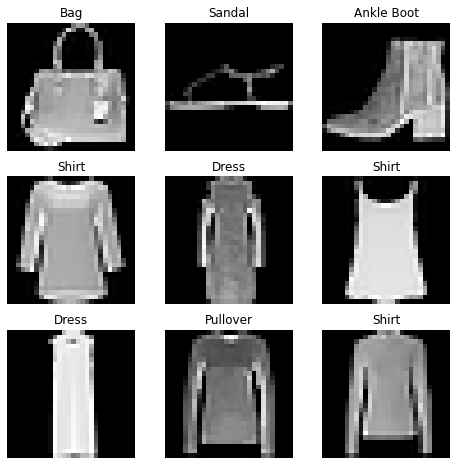

In [3]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

### 파일에서 사용자 정의 데이터셋 만들기

사용자 정의 Dataset 클래스는 반드시 3개 함수를 구현해야 한다 : __init__ , __len__, __getitem__.

아래 구현을 살펴보면 FashionMNIST 이미지들은 img_dir 디렉토리에 저장되고, 정답은 annotations_file csv파일에 별도로 저장된다.

In [4]:
import os 
import pandas as pd
from torchvision.io import read_image

In [5]:
class CustomImageDataset(Dataset):
  def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):    # Dataset 객체가 생성(instatiate)될 때 한 번만 실행
    self.img_labels = pd.read_csv(annotations_file, names=['file_name','label'])
    self.img_dir = img_dir
    self.transform = transform
    self.target_transform = target_transform

  def __len__(self):                           # 데이터셋의 샘플 개수를 반환
    return len(self.img_lables)

  def __getitem__(self, idx):                  # 주어진 인덱스 idx에 해당하는 샘플을 데이터셋에서 불러오고 반환
    img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx,0])  # 인덱스를 기반으로, 디스크에서 이미지의 위치를 식별
    image = read_image(img_path)   # 이미지를 텐서로 변환
    label = self.img_labels.iloc[idx,1]  # csv데이터로부터 해당하는 정답(label)을 가져옴
    if self.transform:
      image = self.transform(image)
    if self.target_transform:
      label = self.target_transform(label)
    return image, label      

### DataLoader로 학습용 데이터 준비하기

Dataset은 데이터셋의 특징(feature)을 가져오고 하나의 샘플에 정답(label)을 지정하는 일을 한 번에 한다. 

모델을 학습할 때, 일반적으로 샘플들을 "미니배치(minibatch)"로 전달하고, 매 epoch마다 데이터를 다시 섞어서 과적합을 막는다.
- DataLoader 는 간단한 API로 이러한 복잡한 과정들을 추상화한 **순회 가능한 객체(iterable)**이다.

In [6]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

### DataLoader를 통해 순회하기(iterate)

DataLoader에 데이터셋을 불러온 뒤에는 필요에 따라 데이터셋을 순회(iterate) 할 수 있다. 

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


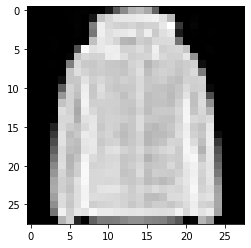

Label: 4


In [9]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

### 변형(Transform)

변형을 통해 데이터를 조작하고 학습에 적합하기 만든다.

In [10]:
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda  ##

In [12]:
ds = datasets.FashionMNIST( root="data", 
                           train=True, 
                           download=True, 
                           transform=ToTensor(),  # PIL Image나 NumPy ndarray를 FloatTensor로 변환하고, 이미지의 픽셀의 크기 값을 [0.,1.]범위로 비례하여 조정(scale)
                           target_transform = Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0,torch.tensor(y), value=1)))
                           # 정수를 원-핫으로 encode된 텐서로 바꾸는 함수를 정의
                           # 먼저 (데이터셋 정답의 개수인) 크기 10짜리 zero tensor를 만들고, scatter_를 호출하여 주어진 정답 y에 해당하는 인덱스에 value=1을 할당